# Performance analysis of BERT for feature extraction

## Eclipse project

| Parameter     | Value         |
| ------------- |:-------------:|
| Model         | bert-base-uncase |
| Tokens        | 128     |
| Threshold     | median      |


In [1]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border: 1px solid lightgray;
    }
</style>

In [2]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

import matplotlib.pyplot as plt
import pandas as pd

import plot_helper  as ph
import stats_helper as sh
%matplotlib inline

reference   = '20210305'
#projects    = ['eclipse', 'freedesktop', 'gcc', 'gnome', 'mozilla', 'winehq']
projects    = ['eclipse', 'freedesktop', 'gcc', 'gnome', 'mozilla', 'winehq']
classifiers = {'knn':0, 'nb':1, 'nn':2, 'rf':3, 'svm':4}
print('setup completed')


setup completed


## RQ1. What is the comparative accuracy of machine learning algorithms when predicting long-lived bugs using BERT as feature extractor?

### Statistical test

In [3]:

for project in projects:
    bert_train_scores = pd.read_csv(f'../../../data/metrics/feature-extraction/{reference}_{project}_feature_extraction_bert_train_scores.csv')
    tfidf_train_scores = pd.read_csv(f'../../../data/metrics/feature-extraction/{reference}_{project}_feature_extraction_tfidf_train_scores.csv')

    best_bert_train_scores = bert_train_scores.copy()
    best_bert_train_scores.loc[:,['classifier']] = best_bert_train_scores['feature_extraction'] + ':' + best_bert_train_scores['classifier']
    
    best_tfidf_train_scores = tfidf_train_scores.copy()
    best_tfidf_train_scores.loc[:,['classifier']] = best_tfidf_train_scores['feature_extraction'] + ':' + best_tfidf_train_scores['classifier']

    all_train_scores = pd.concat([best_bert_train_scores, best_tfidf_train_scores])
    all_train_scores_pivoted = pd.pivot_table (all_train_scores, index='fold', columns='classifier', values=['balanced_acc'])
    
    statistical_test_results = sh.make_test(all_train_scores_pivoted, ['bert:knn', 'bert:nb', 'bert:nn', 'bert:svm', 'bert:rf', 'tf-idf:knn', 'tf-idf:nb', 'tf-idf:nn', 'tf-idf:svm', 'tf-idf:rf'])
    statistical_test_results_sliced = statistical_test_results[['classifier1', 'classifier2', 'direction']]
    statistical_test_results_pivoted = statistical_test_results_sliced.pivot(index='classifier1', columns='classifier2', values='direction')
    
    print(f'Long-lived bug prediction performance statistical test for {project.capitalize()}: BERT versus TF-IDF features')
    #display(statistical_test_results_pivoted)
    #statistical_test_results_pivoted.to_latex(f'tables/rq1-{project}-statistical-test.tex', index=False)
    

Long-lived bug prediction performance statistical test for Eclipse: BERT versus TF-IDF features
Long-lived bug prediction performance statistical test for Freedesktop: BERT versus TF-IDF features
Long-lived bug prediction performance statistical test for Gcc: BERT versus TF-IDF features
Long-lived bug prediction performance statistical test for Gnome: BERT versus TF-IDF features
Long-lived bug prediction performance statistical test for Mozilla: BERT versus TF-IDF features
Long-lived bug prediction performance statistical test for Winehq: BERT versus TF-IDF features


## Performance analysis in testing

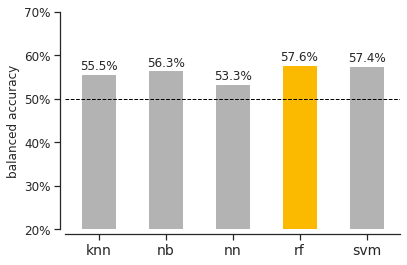

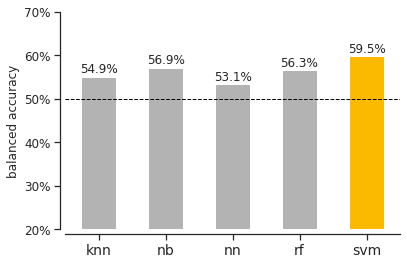

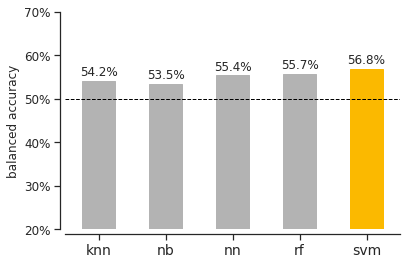

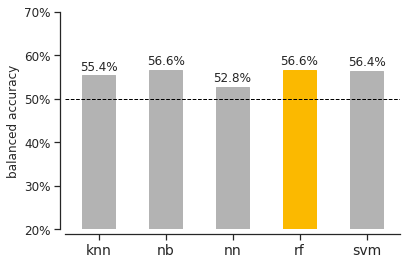

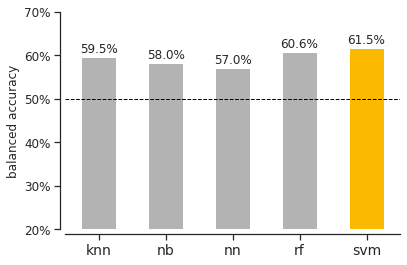

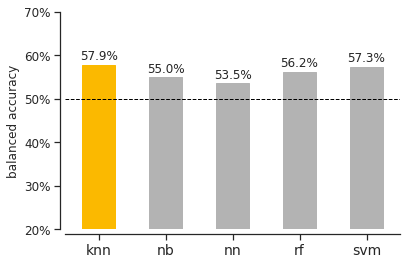

In [4]:
ph.set_style()
classifiers_list = list(classifiers.keys())
for project in projects:
    test_scores_bert  = pd.read_csv(f'../../../data/metrics/feature-extraction/{reference}_{project}_feature_extraction_bert_test_scores.csv')
    #test_scores_bert  = test_scores_bert.loc[test_scores_bert['classifier']!='vc']

    best_balanced_acc_row = test_scores_bert['balanced_acc'].argmax()
    best_classifier = test_scores_bert.iloc[best_balanced_acc_row, 1]
    
    fig, ax =ph.plot_bar(test_scores_bert,  classifiers[best_classifier])
    plt.savefig(f'figures/rq1-{project}-balanced-accuracy.pdf', dpi=600, bbox_inches='tight')

## RQ2.  What is the comparative accuracy of machine learning algorithms when predicting long-lived bugs using BERT and TF-IDF?

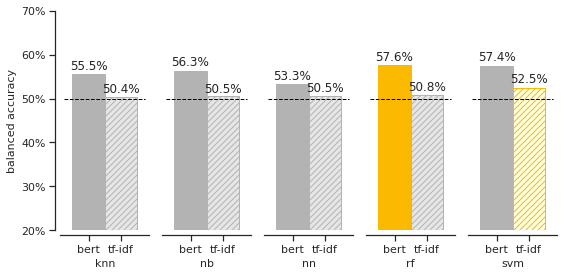

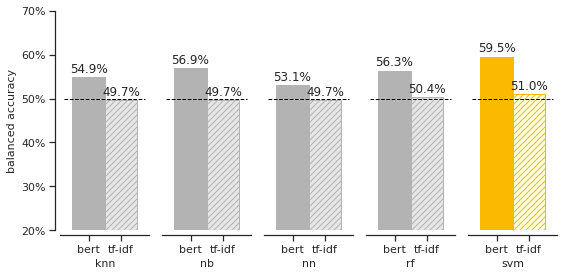

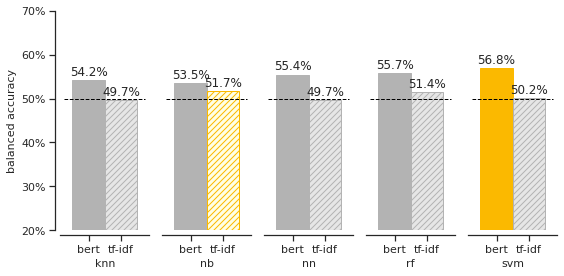

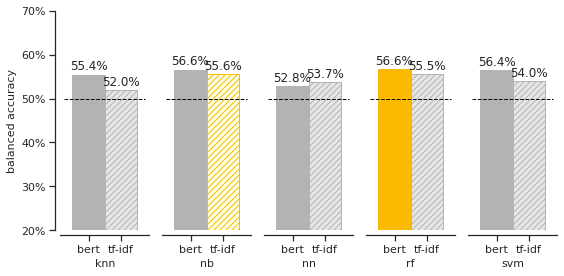

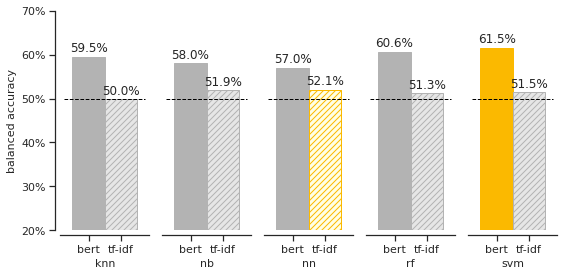

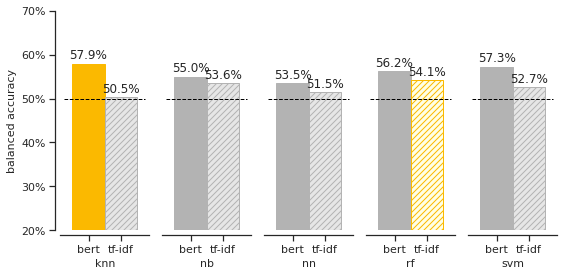

In [5]:
ph.set_style()
classifiers_list = list(classifiers.keys())

for project in projects:
    best_classifier  = []
    test_scores_bert  = pd.read_csv(f'../../../data/metrics/feature-extraction/{reference}_{project}_feature_extraction_bert_test_scores.csv')
    best_balanced_acc_row = test_scores_bert['balanced_acc'].argmax()
    best_classifier.append(test_scores_bert.iloc[best_balanced_acc_row, 1])
    
    test_scores_tfidf = pd.read_csv(f'../../../data/metrics/feature-extraction/{reference}_{project}_feature_extraction_tfidf_test_scores.csv')
    best_balanced_acc_row = test_scores_tfidf['balanced_acc'].argmax()
    best_classifier.append(test_scores_tfidf.iloc[best_balanced_acc_row, 1])
    
    test_scores = pd.concat([test_scores_bert, test_scores_tfidf])
    
    fig, axes =ph.plot_stacked_bar(test_scores, classifiers_list)
    ph.make_labels(fig, axes, project, classifiers_list)
    ph.set_size(fig)
    ph.color_bars(axes, ph.get_colors(), classifiers[best_classifier[0]], classifiers[best_classifier[1]])
    plt.savefig(f'figures/rq2-{project}-balanced-accuracy.pdf', dpi=600, bbox_inches='tight')

## RQ3. What are the main characteristics of bugs correctly predicted as long-lived and incorrectly predicted as short-lived when using BERT vs TF-IDF?

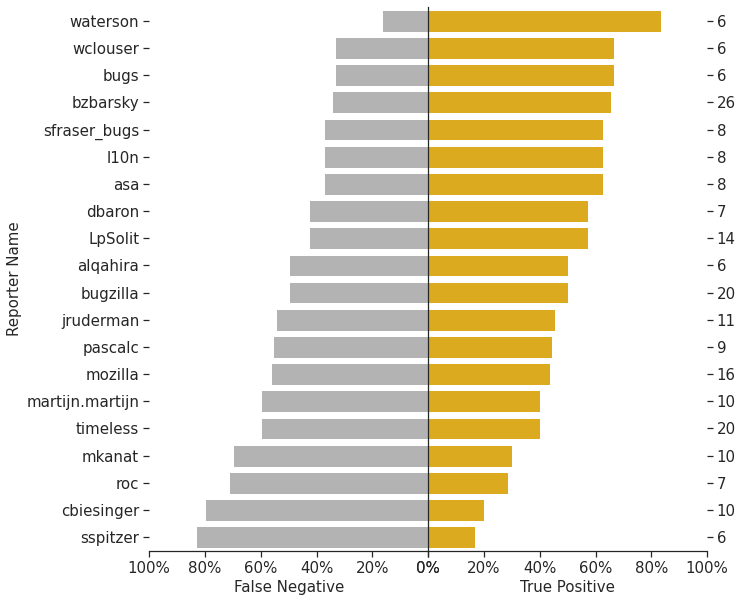

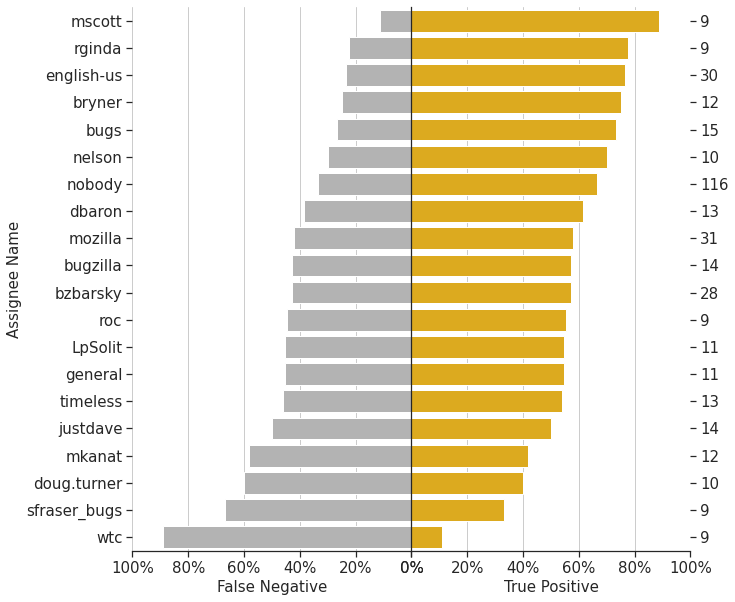

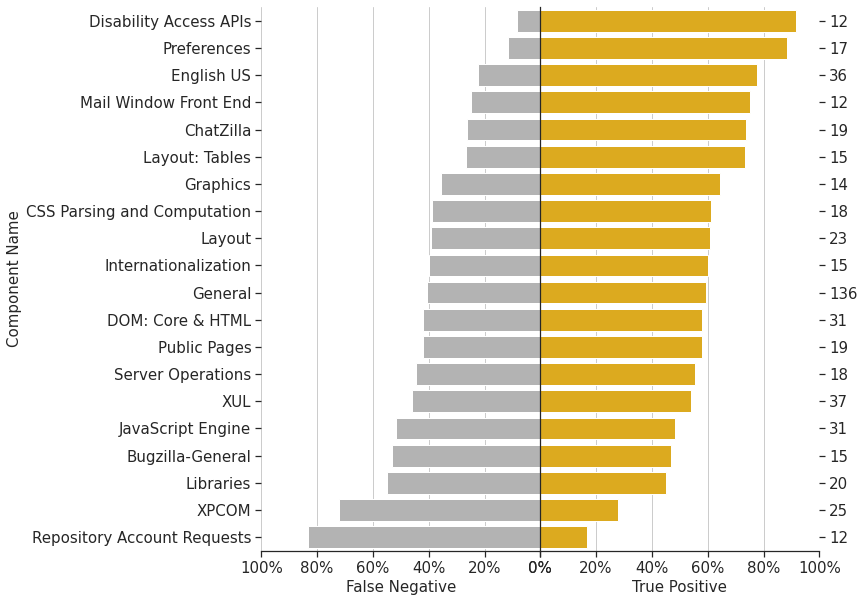

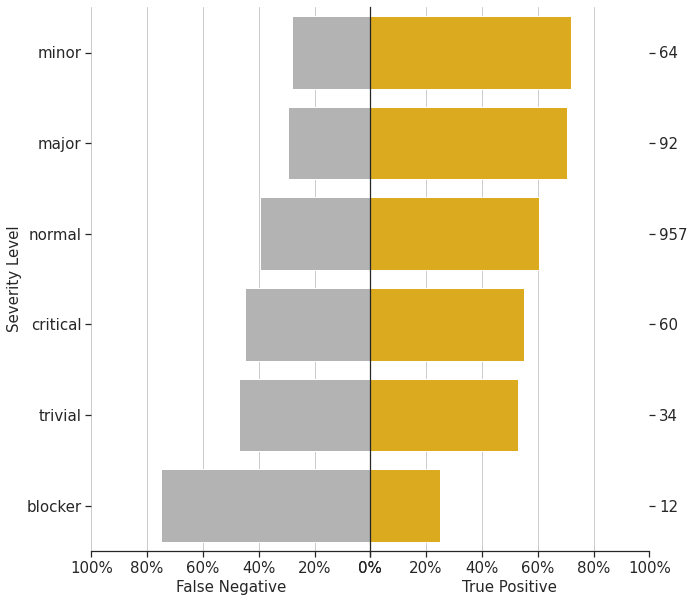

In [6]:
reports_predictions_data_bert = []
for project in ['mozilla']:
    reports_raw_path = f"../../../data/raw/{project}_bug_report_data.csv"
    reports_raw_data = pd.read_csv(reports_raw_path)
    reports_clean_path = f"../../../data/clean/{reference}_{project}_bug_report_test_data.csv"
    reports_clean_data = pd.read_csv(reports_clean_path)
    predictions_path = f"../../../data/metrics/feature-extraction/{reference}_{project}_feature_extraction_bert_test_predictions.csv"
    predictions_data = pd.read_csv(predictions_path)
    
    reports_predictions_data = pd.merge(
        reports_raw_data[['bug_id', 'component_name', 'assignee_name', 'reporter_name', 'severity_category']],
        reports_clean_data[['bug_id', 'long_description']],
        left_on='bug_id',
        right_on='bug_id',
        how='inner'
    )

    reports_predictions_data = pd.merge(
        reports_predictions_data,
        predictions_data,
        left_on='bug_id',
        right_on='bug_id',
        how='inner'
    )
    
    reports_predictions_data = reports_predictions_data[reports_predictions_data.y_test == 1]
    reports_predictions_data.loc[reports_predictions_data.y_test == 1, 'prediction_status'] = reports_predictions_data['y_hat'].apply(lambda t: 'True Positive' if t == 1 else 'False Negative')
    reports_predictions_data=reports_predictions_data.loc[reports_predictions_data['classifier']=='svm']
    top_n_bert = {}
    for column in ['reporter_name', 'assignee_name', 'component_name', 'severity_category']:
        top_n_bert[column]=ph.plot_pyramid(project, reports_predictions_data, column, 20, 'bert')[column].values
        plt.savefig(f'figures/rq3-{project}-bert-top-{column}.pdf', dpi=600, bbox_inches='tight')

    reports_predictions_data_bert = reports_predictions_data[:]

In [7]:
def plot_wordcloud(project, feature_extractor, data, column):
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    sentences = " ".join(s.strip() for s in data[column])
    wordcloud=WordCloud(  max_font_size=50
                        , max_words=128
                        , background_color='white'
                        , colormap='Set2'
                        , collocations=False).generate(sentences)
    
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    wordcloud.to_file(f"figures/rq3-{project}-{feature_extractor}-{column}-wordcloud.pdf")
 
    return wordcloud

def get_words(text):
    def mutate_dict(f,d):
        for k, v in zip(d.keys(), d.values()):
            d[k] = f(v)
    
        return d

    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    sentences = " ".join(s.strip() for s in text)
    wordcloud=WordCloud(max_words=128, collocations=False).generate(sentences)
    
    #return mutate_dict(lambda x: x*100, wordcloud.words_)
    return wordcloud.words_

def plot_venn_wordcloud(project, fe, data1, label1, data2, label2, column, max_words=128):
    from matplotlib_venn_wordcloud import venn2_wordcloud 
    fig, ax = plt.subplots(figsize=(10, 10))
    
    words1  = get_words(data1[column])
    words2  = get_words(data2[column])
    
    v = venn2_wordcloud([set(words1.keys()), set(words2.keys())]
                        , set_labels=[label1, label2]
                        #, word_to_frequency=dict(words1, **words2)
                        , ax=ax)
    v.get_patch_by_id('10').set_color('white')
    
    v.get_patch_by_id('10').set_alpha(0.4)
    v.get_patch_by_id('01').set_color('white')
    v.get_patch_by_id('01').set_alpha(0.4)
    v.get_patch_by_id('11').set_color('gray')
    v.get_patch_by_id('11').set_alpha(0.4)
    plt.savefig(f"figures/rq3-{project}-{fe}-venn-wordcloud.pdf", dpi=600, bbox_inches='tight')
 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


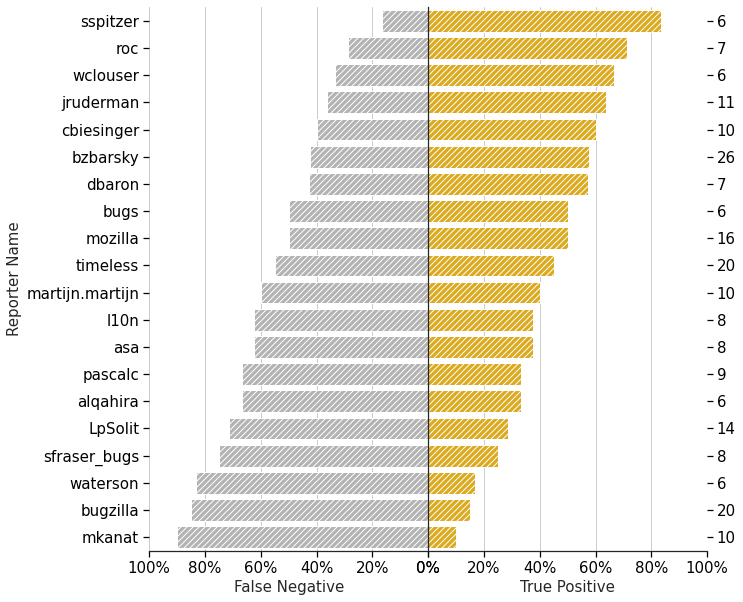

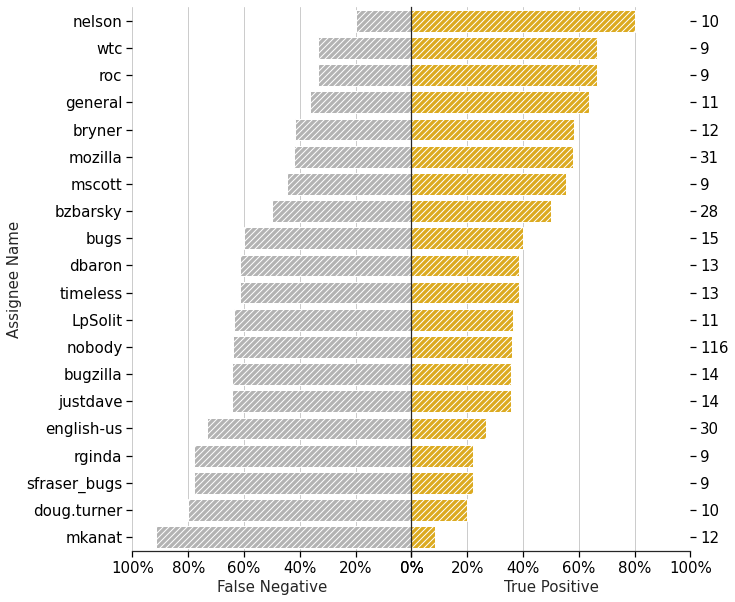

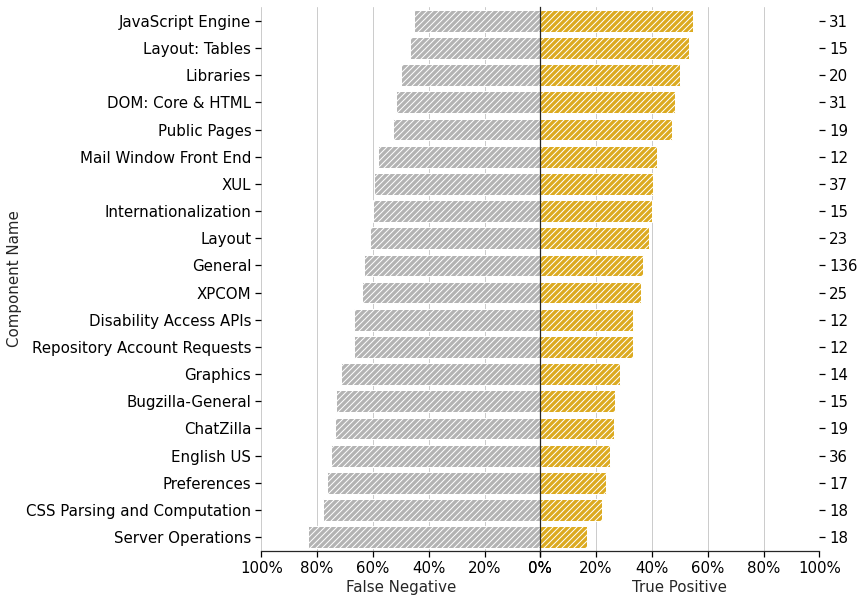

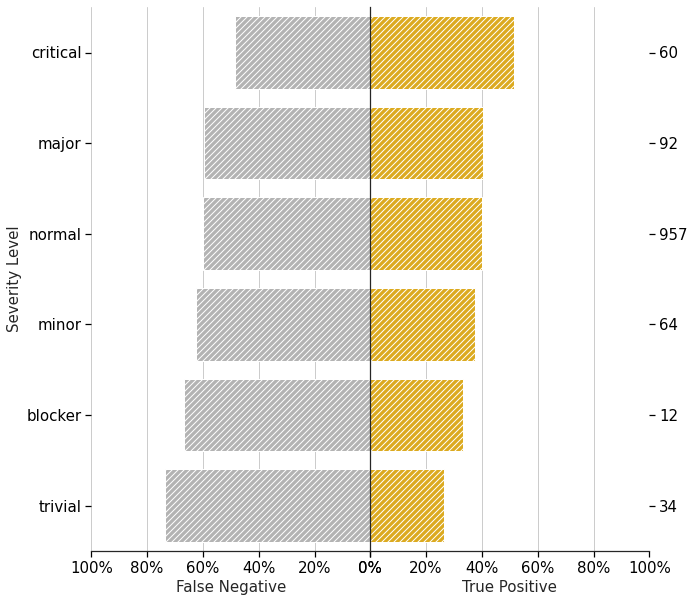

In [29]:
for project in ['mozilla']:
    reports_raw_path = f"../../../data/raw/{project}_bug_report_data.csv"
    reports_raw_data = pd.read_csv(reports_raw_path)
    reports_clean_path = f"../../../data/clean/{reference}_{project}_bug_report_test_data.csv"
    reports_clean_data = pd.read_csv(reports_clean_path)
    predictions_path = f"../../../data/metrics/feature-extraction/{reference}_{project}_feature_extraction_tfidf_test_predictions.csv"
    predictions_data = pd.read_csv(predictions_path)
    reports_predictions_data = pd.merge(
        reports_raw_data[['bug_id', 'component_name', 'assignee_name', 'reporter_name', 'severity_category']],
        reports_clean_data[['bug_id', 'long_description']],
        left_on='bug_id',
        right_on='bug_id',
        how='inner'
    )
    reports_predictions_data = pd.merge(
        reports_predictions_data,
        predictions_data,
        left_on='bug_id',
        right_on='bug_id',
        how='inner'
    )
    
    reports_predictions_data = reports_predictions_data[reports_predictions_data.y_test == 1]
    reports_predictions_data.loc[reports_predictions_data.y_test == 1, 'prediction_status'] = reports_predictions_data['y_hat'].apply(lambda t: 'True Positive' if t == 1 else 'False Negative')
    reports_predictions_data=reports_predictions_data.loc[reports_predictions_data['classifier']=='nn']
    top_n_tfidf = {}
    for column in ['reporter_name', 'assignee_name', 'component_name', 'severity_category']:
        top_n_tfidf[column] = ph.plot_pyramid(project, reports_predictions_data, column, 20, 'tfidf')[column].values
        plt.savefig(f'figures/rq3-{project}-tfidf-top-{column}.pdf', dpi=600, bbox_inches='tight')
    
    reports_predictions_data_tfidf = reports_predictions_data[:]

In [8]:
top_severity_bert = reports_predictions_data_bert.loc[reports_predictions_data_bert['severity_category'].isin (['minor']), ['bug_id', 'reporter_name', 'long_description', 'prediction_status', 'feature_extraction']]
top_severity_bert['sentence'] = top_severity_bert['long_description'].apply((lambda s: ' '.join(s.split()[:128])))

bot_severity_bert = reports_predictions_data_bert.loc[reports_predictions_data_bert['severity_category'].isin (['blocker']), ['bug_id', 'reporter_name', 'long_description', 'prediction_status', 'feature_extraction']]
bot_severity_bert['sentence'] = bot_severity_bert['long_description'].apply((lambda s: ' '.join(s.split()[:128])))


top_severity_tfidf = reports_predictions_data_tfidf.loc[reports_predictions_data_tfidf['severity_category'].isin (['critical']), ['bug_id', 'reporter_name', 'long_description', 'prediction_status', 'feature_extraction']]
top_severity_tfidf['sentence'] = top_severity_tfidf['long_description'].apply((lambda s: ' '.join(s.split()[:128])))

bot_severity_tfidf = reports_predictions_data_tfidf.loc[reports_predictions_data_tfidf['severity_category'].isin (['trivial']), ['bug_id', 'reporter_name', 'long_description', 'prediction_status', 'feature_extraction']]
bot_severity_tfidf['sentence'] = bot_severity_tfidf['long_description'].apply((lambda s: ' '.join(s.split()[:128])))


In [9]:
wc_bert=plot_wordcloud('mozilla', 'bert',  top_severity_bert, 'sentence')
wc_tfidf=plot_wordcloud('mozilla', 'tfidf', top_severity_tfidf, 'sentence')


NameError: name 'plot_wordcloud' is not defined

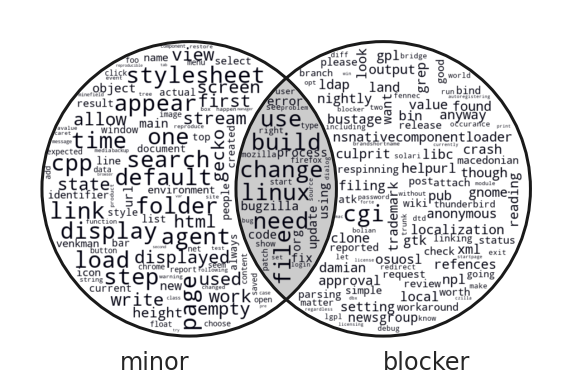

In [11]:
plot_venn_wordcloud('mozilla', 'bert', top_severity_bert, 'minor', bot_severity_bert, 'blocker', 'sentence')

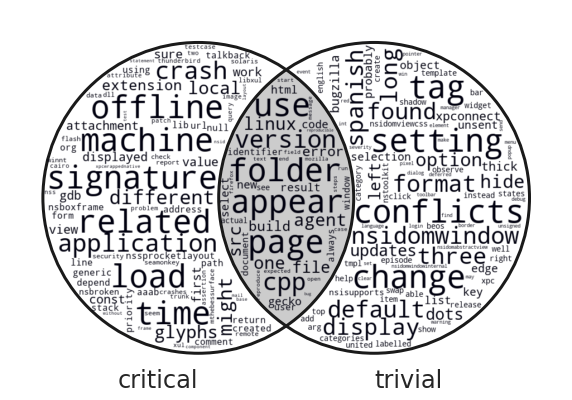

In [12]:
plot_venn_wordcloud('mozilla', 'tfidf', top_severity_tfidf, 'critical', bot_severity_tfidf, 'trivial', 'sentence')

# BERT

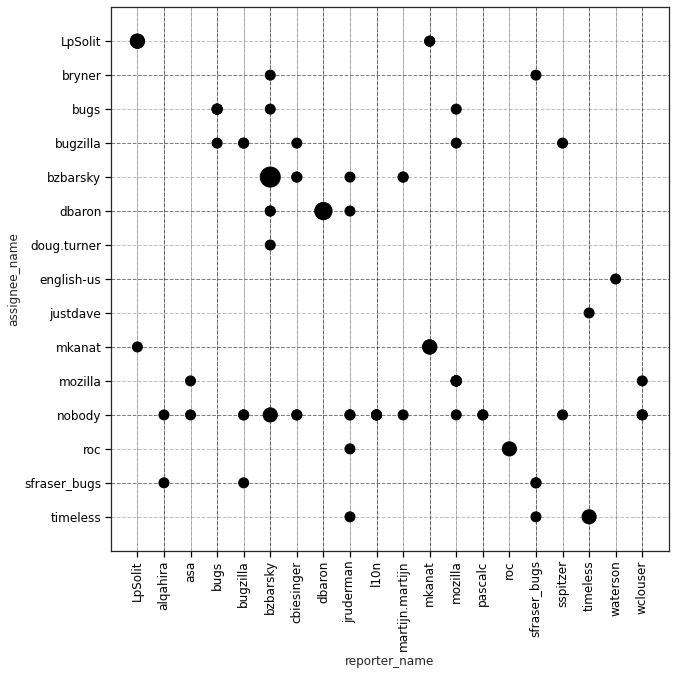

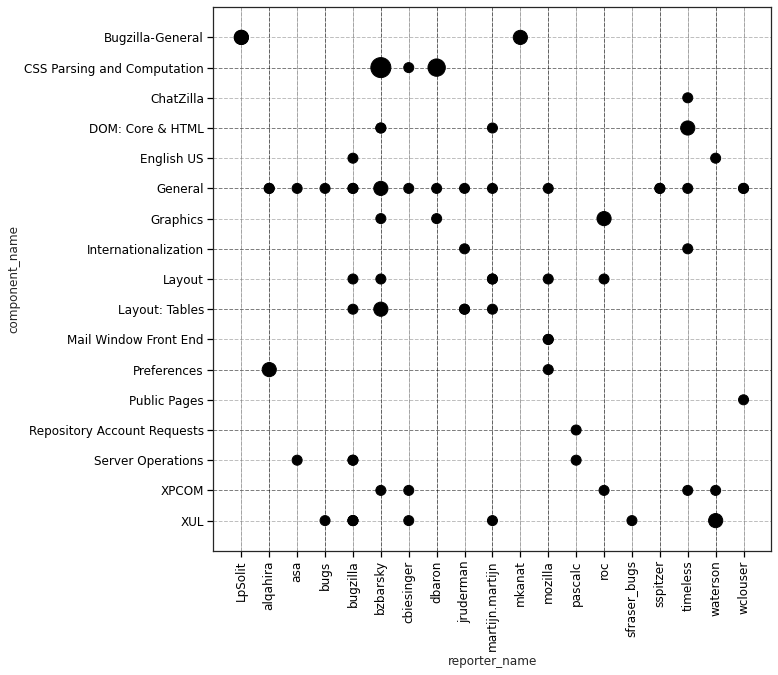

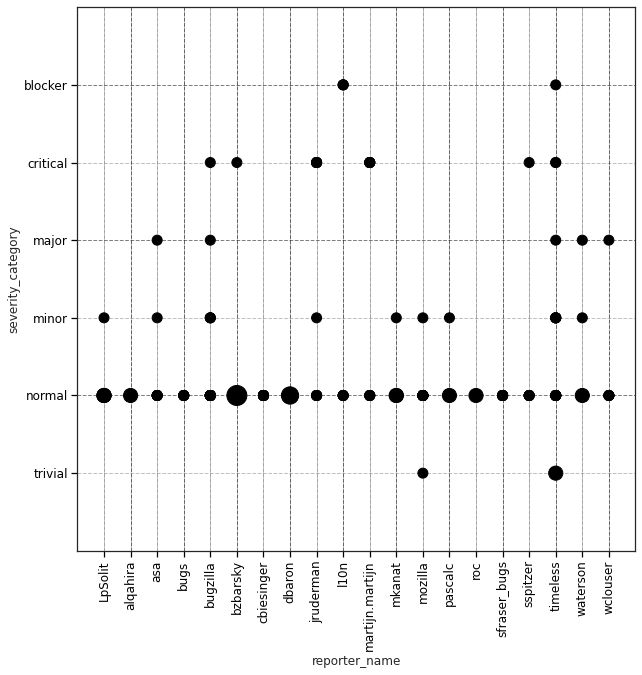

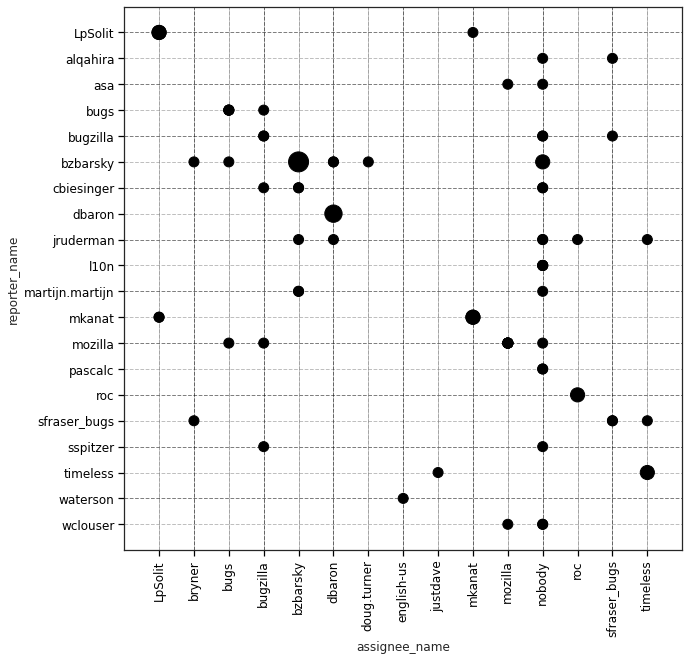

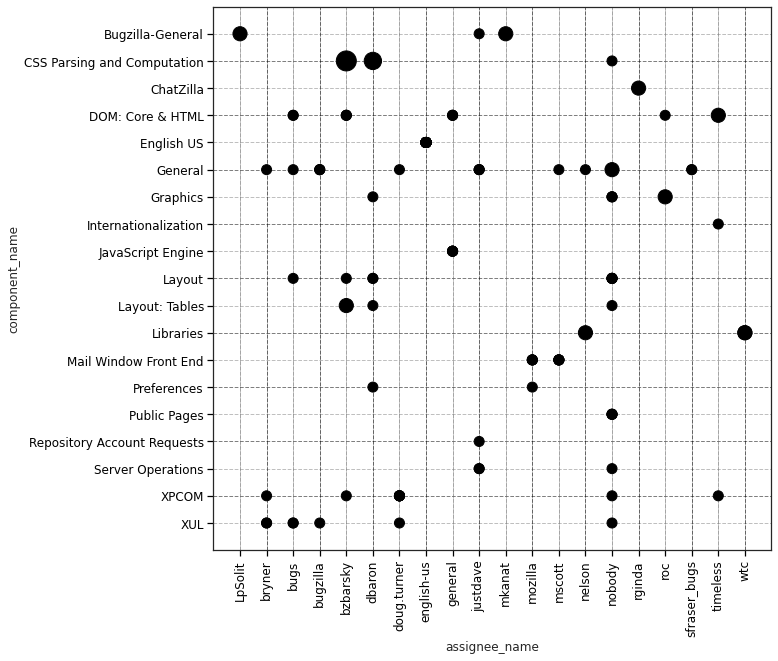

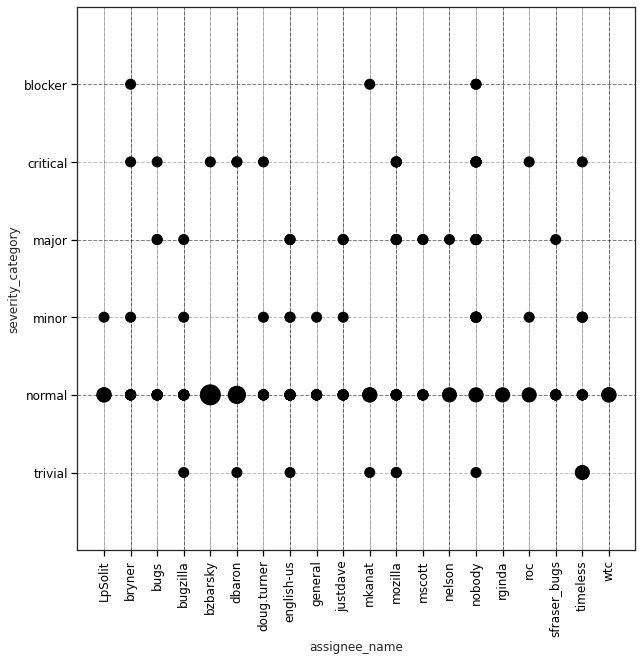

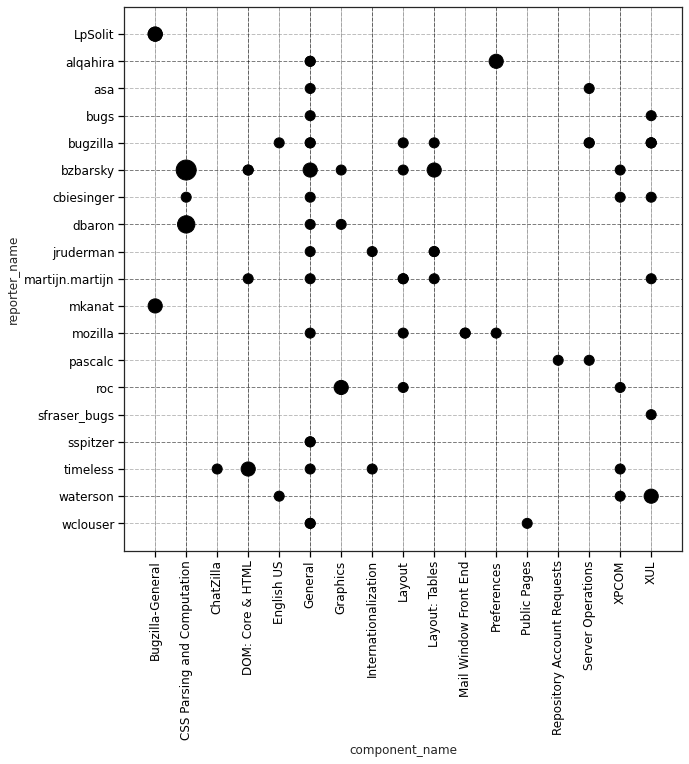

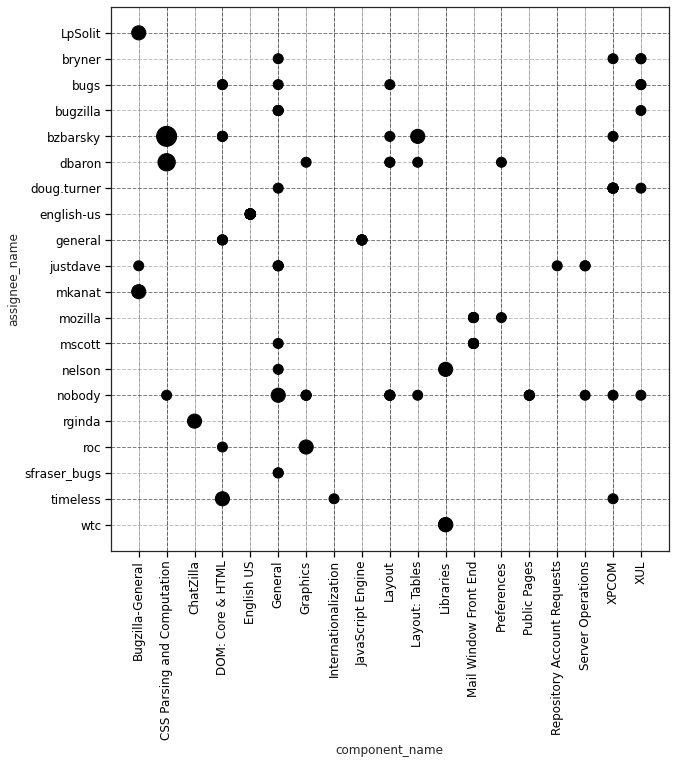

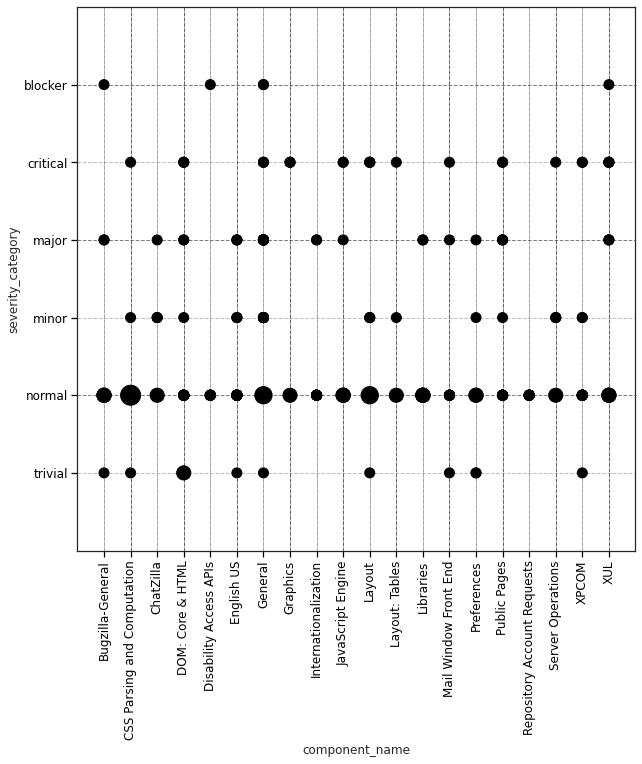

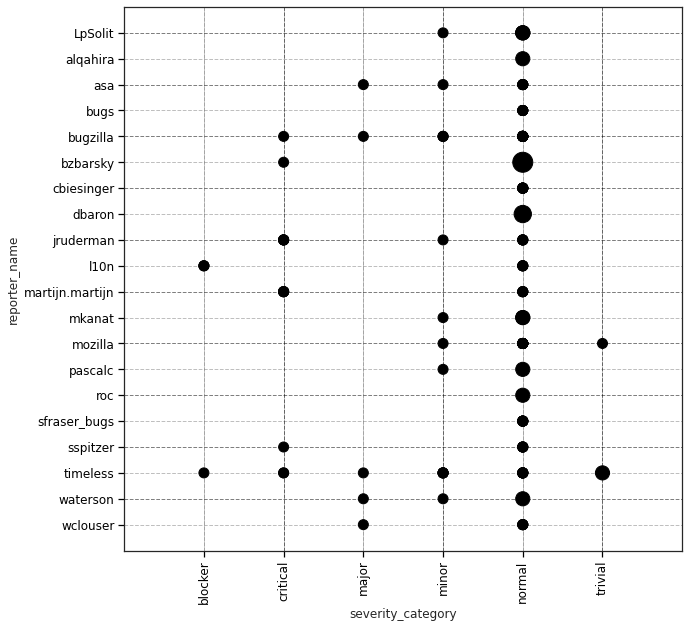

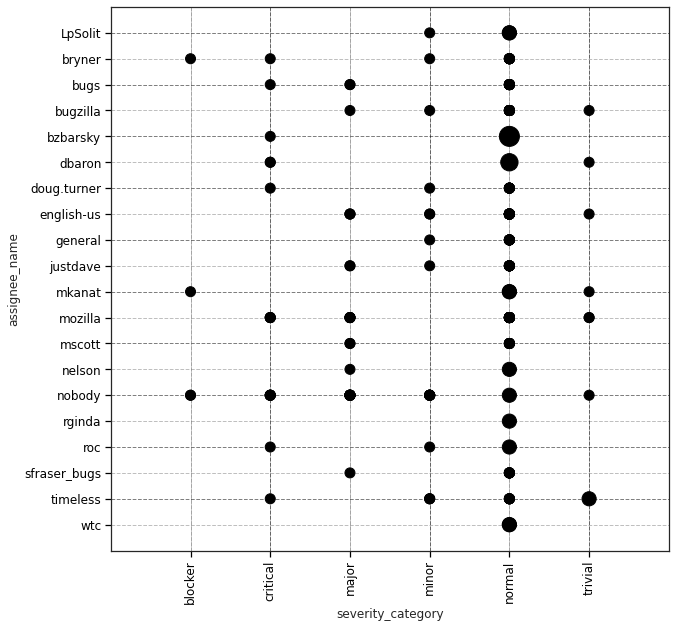

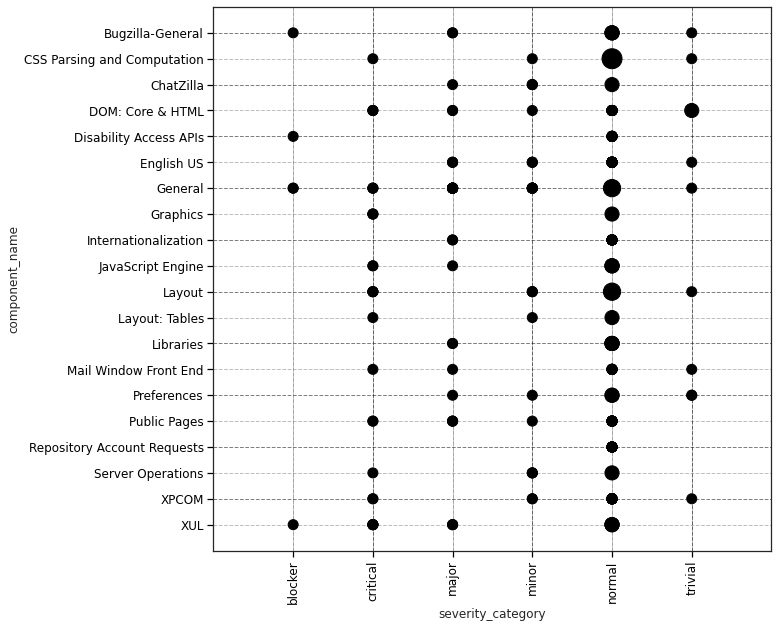

In [32]:
cols=['reporter_name', 'assignee_name', 'component_name', 'severity_category']
df = reports_predictions_data_bert[cols]
df_grouped = df.groupby(['reporter_name', 'assignee_name','component_name', 'severity_category']).size().reset_index(name='count')

for colx in cols:
    for coly in cols:
        if colx != coly:
            df_filtered=df_grouped.loc[df_grouped[colx].isin(top_n_bert[colx])] 
            df_filtered=df_filtered.loc[df_filtered[coly].isin(top_n_bert[coly])] 

            fig = plt.figure(figsize=(10,10))
            ph.catscatter(df_filtered, colx, coly, 'count', ratio=100)
            plt.savefig(f'figures/rq3-mozilla-bert-{colx}-vs-{coly}.pdf', dpi=600)


# TF-IDF

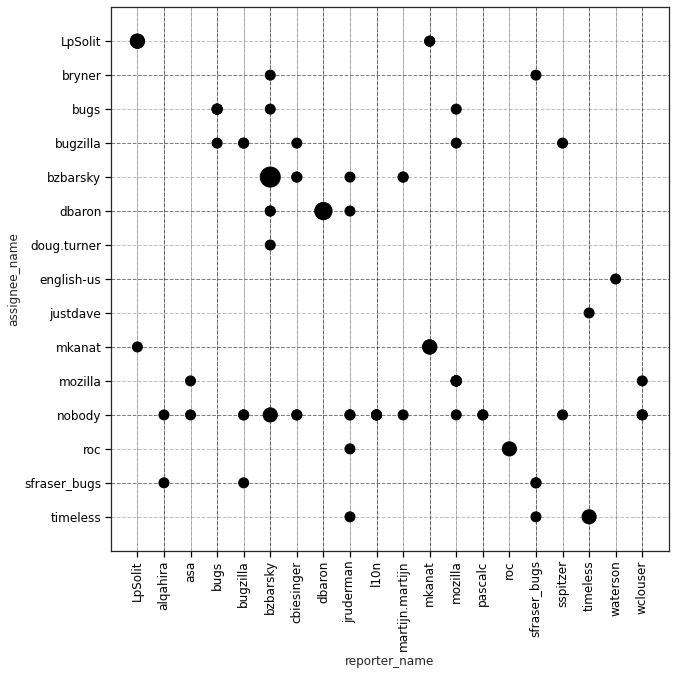

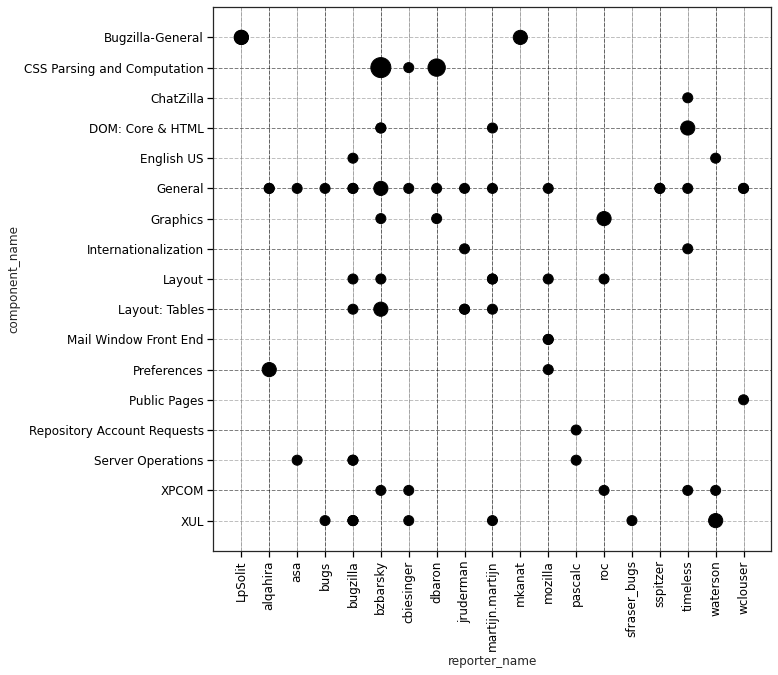

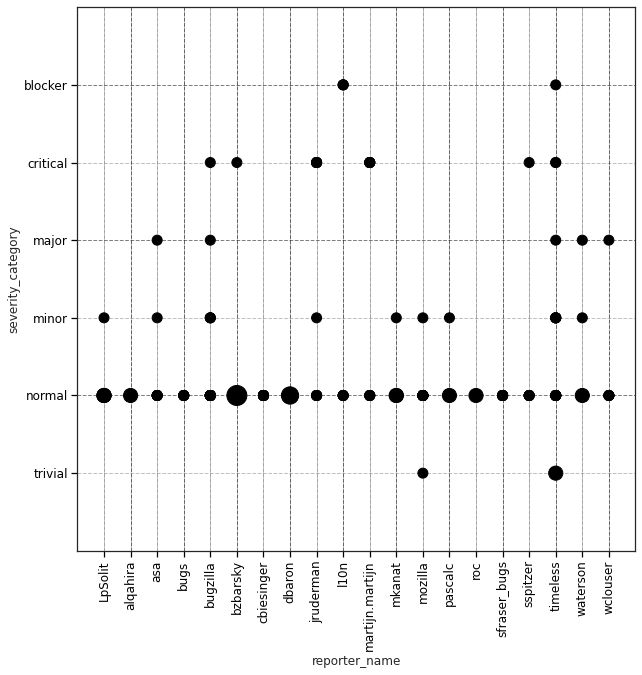

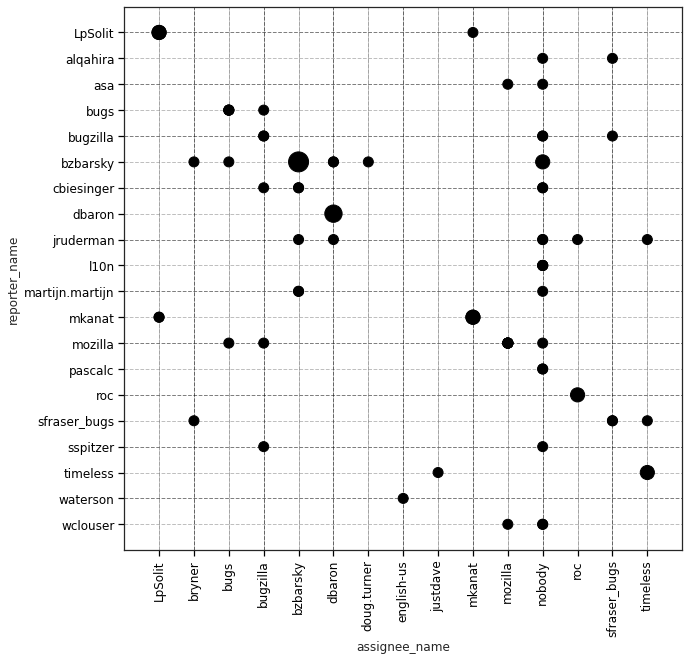

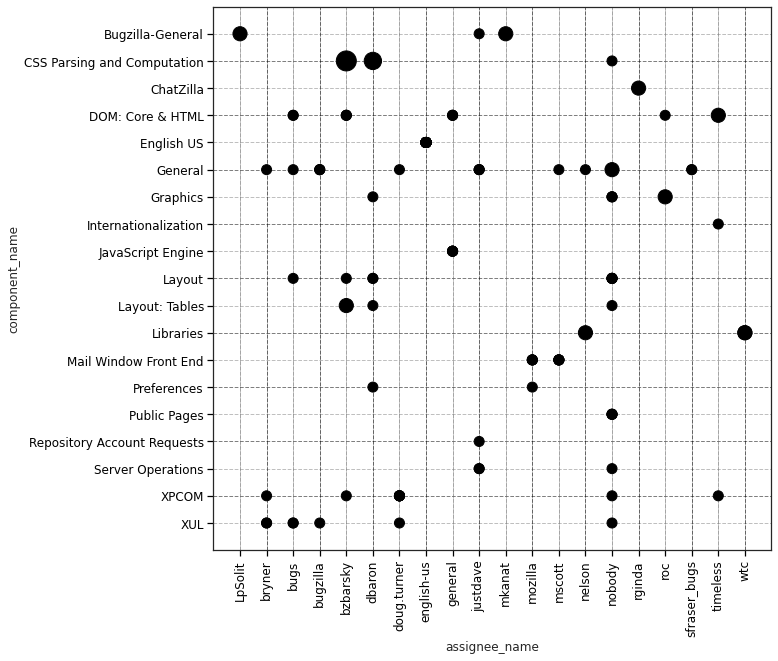

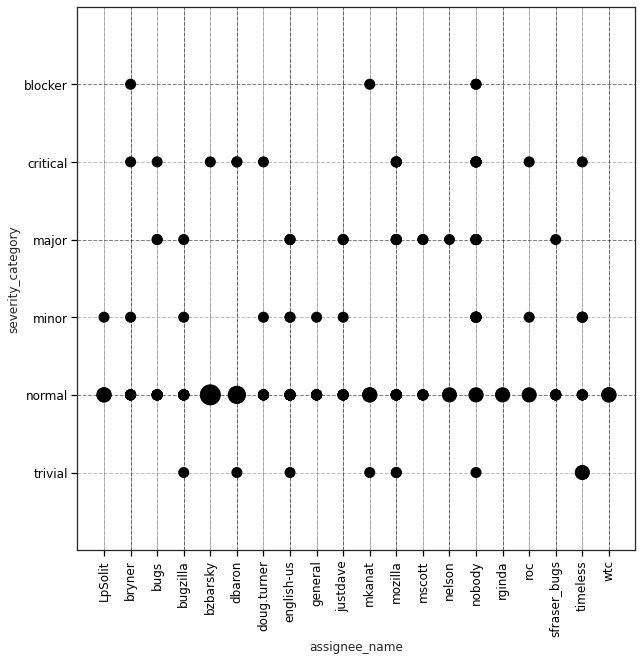

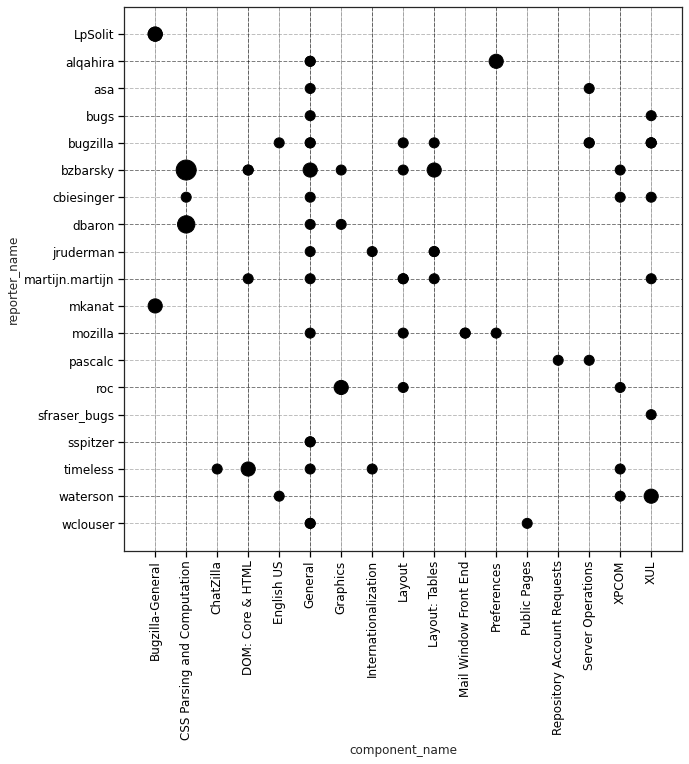

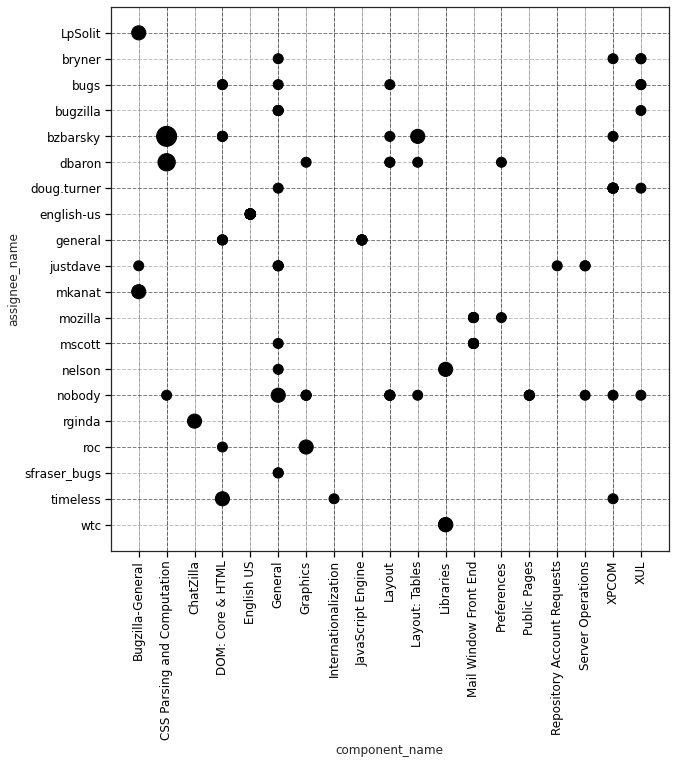

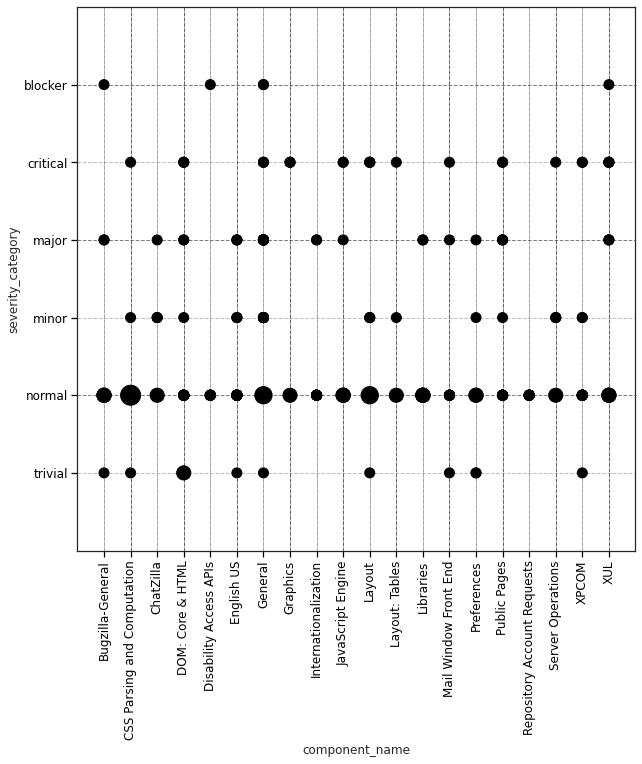

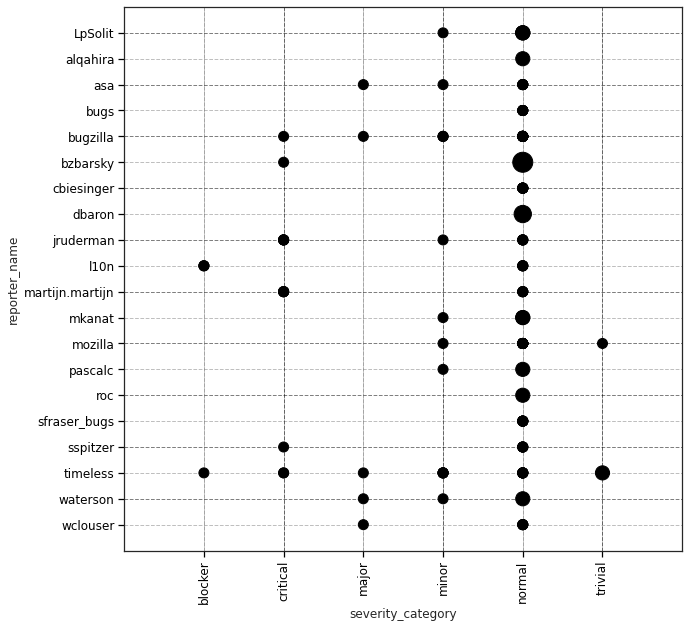

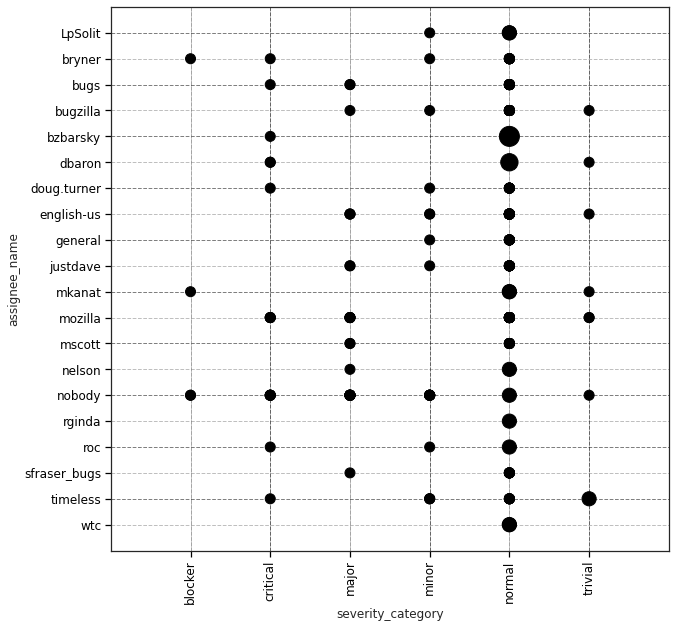

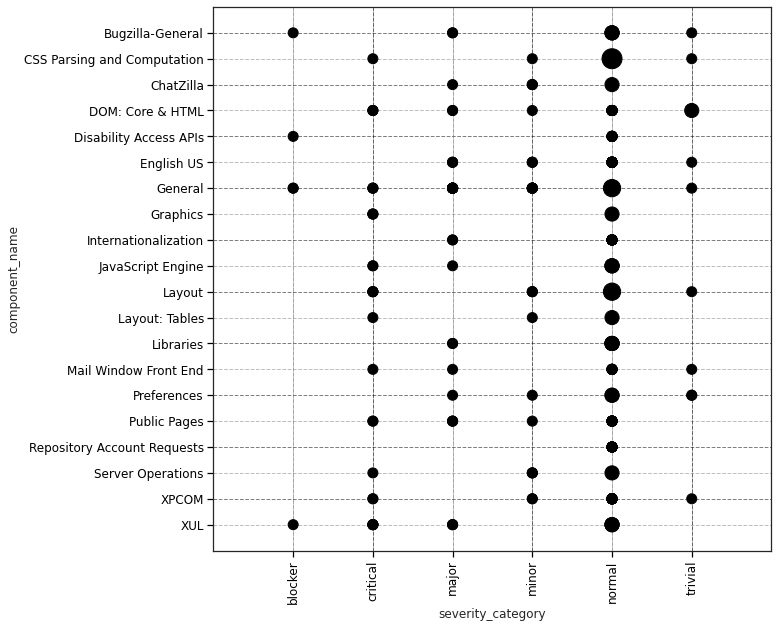

In [31]:
cols=['reporter_name', 'assignee_name', 'component_name', 'severity_category']
df = reports_predictions_data_tfidf[cols]
df_grouped = df.groupby(['reporter_name', 'assignee_name','component_name', 'severity_category']).size().reset_index(name='count')

for colx in cols:
    for coly in cols:
        if colx != coly:
            df_filtered=df_grouped.loc[df_grouped[colx].isin(top_n_tfidf[colx])] 
            df_filtered=df_filtered.loc[df_filtered[coly].isin(top_n_tfidf[coly])] 

            fig = plt.figure(figsize=(10,10))
            ph.catscatter(df_filtered, colx, coly, 'count', ratio=100)
            plt.savefig(f'figures/rq3-mozilla-tfif-{colx}-vs-{coly}.pdf', dpi=600)


In [27]:
df_grouped.loc[df_grouped['assignee_name']=='sspitzer']

,reporter_name,assignee_name,count
432,hskupin,sspitzer,1
888,sekundes,sspitzer,1
925,sspitzer,sspitzer,1
971,tetsuroy,sspitzer,1


In [28]:
top_n_

{'reporter_name': array(['waterson', 'wclouser', 'bugs', 'bzbarsky', 'sfraser_bugs', 'l10n',
        'asa', 'dbaron', 'LpSolit', 'alqahira', 'bugzilla', 'jruderman',
        'pascalc', 'mozilla', 'martijn.martijn', 'timeless', 'mkanat',
        'roc', 'cbiesinger', 'sspitzer'], dtype=object),
 'assignee_name': array(['mscott', 'rginda', 'english-us', 'bryner', 'bugs', 'nelson',
        'nobody', 'dbaron', 'mozilla', 'bugzilla', 'bzbarsky', 'roc',
        'LpSolit', 'general', 'timeless', 'justdave', 'mkanat',
        'doug.turner', 'sfraser_bugs', 'wtc'], dtype=object),
 'component_name': array(['Disability Access APIs', 'Preferences', 'English US',
        'Mail Window Front End', 'ChatZilla', 'Layout: Tables', 'Graphics',
        'CSS Parsing and Computation', 'Layout', 'Internationalization',
        'General', 'DOM: Core & HTML', 'Public Pages', 'Server Operations',
        'XUL', 'JavaScript Engine', 'Bugzilla-General', 'Libraries',
        'XPCOM', 'Repository Account Requests'],

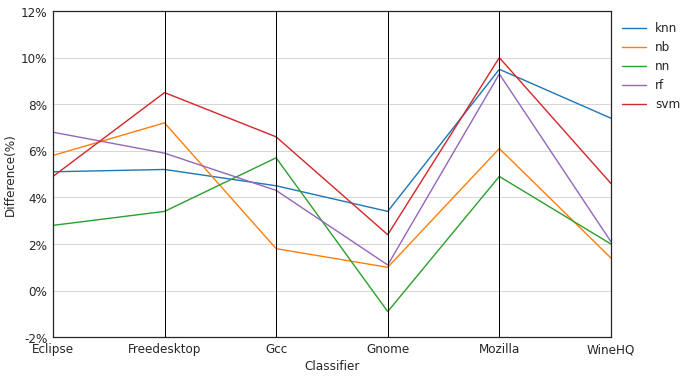

In [89]:

from pandas.plotting import parallel_coordinates
import seaborn as sns

diff_dict = {
    'Eclipse':{'knn':5.1,      'nb':5.8, 'nn':2.8, 'rf':6.8, 'svm':4.9},
    'Freedesktop':{'knn':5.2,  'nb':7.2, 'nn':3.4, 'rf':5.9, 'svm':8.5},
    'Gcc': {'knn':4.5,         'nb':1.8, 'nn':5.7, 'rf':4.3, 'svm':6.6},
    'Gnome': {'knn':3.4,       'nb':1.0, 'nn':-0.9, 'rf':1.1, 'svm':2.4},
    'Mozilla': {'knn':9.5,     'nb':6.1, 'nn':4.9, 'rf':9.3, 'svm':10.0},
    'WineHQ': {'knn':7.4,      'nb':1.4, 'nn':2.0, 'rf':2.1, 'svm':4.6}
}

diff_dict = {
    'knn':{'Eclipse':5.1, 'Freedesktop':5.2, 'Gcc':4.5, 'Gnome':3.4, 'Mozilla':9.5, 'WineHQ':7.4},
    'nb':{'Eclipse':5.8, 'Freedesktop':7.2, 'Gcc':1.8, 'Gnome':1.0, 'Mozilla':6.1, 'WineHQ':1.4},
    'nn': {'Eclipse':2.8, 'Freedesktop':3.4, 'Gcc':5.7, 'Gnome':-0.9, 'Mozilla':4.9, 'WineHQ':2.0},
    'rf': {'Eclipse':6.8, 'Freedesktop':5.9, 'Gcc':4.3, 'Gnome':1.1, 'Mozilla':9.3, 'WineHQ':2.1},
    'svm': {'Eclipse':4.9, 'Freedesktop':8.5, 'Gcc':6.6, 'Gnome':2.4, 'Mozilla':10.0, 'WineHQ':4.6}
}

cls=classifiers.keys()
eclipse=[5.1, 5.8, 2.8, 6.8, 4.9, 5.1]
freedesktop=[5.2, 7.2, 3.4, 5.9, 8.5, 5.2]
gcc=[4.5, 1.8, 5.7, 4.3, 6.6, 4.5]
gnome=[3.4, 1.0, -0.9, 1.1, 2.4, 3.4]
mozilla=[9.5, 6.1, 4.9, 9.3, 10.0, 9.5]
winehq=[7.4, 1.4, 2.0, 2.1, 4.6, 7.4]


diff_df = pd.DataFrame.from_dict(diff_dict, orient='index')
diff_df = diff_df.reset_index()
diff_df = diff_df.rename(columns={'index':'dataset'})


with plt.style.context(("seaborn-white", "seaborn-paper")):
    fig = plt.figure(figsize=(10,6))
    _=parallel_coordinates(diff_df, 
                           "dataset",
                           color=["tab:blue", "tab:orange","tab:green", "tab:purple","tab:red", "tab:pink"],
                           alpha=1)

    #plt.title("% of balanced accuracy diffence between BERT-Base and TF-IDF")
    plt.ylabel("Difference(%)", fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(-2, 12)
    
    plt.xlabel("Classifier", fontsize=12)
    plt.xticks(fontsize=12)
    
    _=plt.gca().legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 12})
    _=plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()])
    plt.savefig(f'figures/rq2-all-difference-bert-vs-tfidf.pdf', dpi=600, bbox_inches='tight')

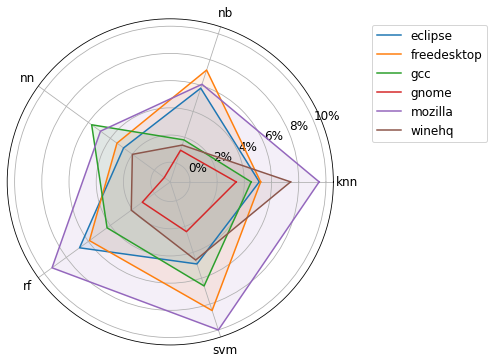

In [106]:
import numpy as np
plt.figure(figsize=(10,6))
plt.subplot(polar=True)
theta    = np.linspace(0, 2 * np.pi, 6)
lines, labels = plt.thetagrids(range(0, 360, int(360/len(cls))), (cls))

plt.plot(theta, eclipse)
plt.fill(theta, eclipse, alpha=0.1)

plt.plot(theta, freedesktop)
plt.fill(theta, freedesktop, alpha=0.1)

plt.plot(theta, gcc)
plt.fill(theta, gcc, alpha=0.1)


plt.plot(theta, gnome)
plt.fill(theta, gnome, alpha=0.0)

plt.plot(theta, mozilla)
plt.fill(theta, mozilla, alpha=0.1)

plt.plot(theta, winehq)
plt.fill(theta, winehq, alpha=0.1)

plt.ylabel("", fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(-2, 12)
    
plt.xlabel("", fontsize=12)
plt.xticks(fontsize=12)
    

plt.legend(labels=projects, loc='upper left', bbox_to_anchor=(1.1, 1), fontsize=12)
_=plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()])
    
plt.savefig(f'figures/rq2-all-difference-bert-vs-tfidf.pdf', dpi=600, bbox_inches='tight')

In [66]:
diff_dict['knn'].values()

dict_values([5.1, 5.2, 4.5, 3.4, 9.5, 7.4, 5.1])